1. linreg for EGTM, 1 engine only
2. tune theta degree
3. tune altitude + bleed ensemble

In [1]:
from deltas import *

bdu_all = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2')

bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2 and reportts >= "2019-01-05"')

In [2]:
acms_full = pd.read_csv(
  './data/neo_takeoff_202404192324.csv', 
  parse_dates=['reportts'], 
  low_memory=False
).sort_values('reportts', ignore_index=True)

acms_full.shape

(253920, 204)

In [3]:
alpha = 0.5
alpha_2 = 0.884

In [4]:
def theta_correct(data, x_param, y_param, theta_param, alpha2 = alpha_2):
  mach_k = 1.0 + 0.2 * (data['mn_peak'] ** 2)
  theta = (data[theta_param] + 273.16) / (288.16 * mach_k)
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (0 + theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data


def combination_to_number (comb: tuple[bool]):
    if len(comb) == 0:
        return 0
    a = map(int, comb)
    return int(''.join(map(str, a)))


assert combination_to_number((True, False, True)) == 101
assert combination_to_number((False, False, False)) == 0

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin
import itertools
import numpy as np

class EGTMarginRegressor(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            fleet = [],
            x_param = 'n1a_peak',
            y_param = 'egt_peak',
            theta_param = 'tat_peak',
            bleed_config = ['prv'],
            alt_split = None,
            early_range = [50, 200],
            theta_alpha = alpha_2,
            filter_nan = True,
            acms_data = None,
        ):
        self.fleet = fleet
        self.x_param = x_param
        self.y_param = y_param
        self.theta_param = theta_param
        self.bleed_config = bleed_config
        self.alt_split = alt_split
        self.early_range = early_range
        self.theta_alpha = theta_alpha
        self.smooth_factor = 0.05
        self.filter_nan = filter_nan
        self.acms_data = acms_data

    def _get_bleed_filter_index(self, X, comb: tuple[bool]):
        assert len(comb) == len(self.bleed_config)
        index = X.iloc[:, 0] == X.iloc[:, 0]

        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (X[field_name] == comb[i])

        return index
    

    def fit(self, X, y):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()
        
        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, self.theta_alpha)
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'
        Xk, y = Xk[X_filter], y[X_filter]

        # *separate* baseline for each bleed config
        # later try single baseline for engine 
        # but fit linreg to each bleed conf separately

        self.ensemble = LinearRegression()
        self.ensemble.coef_ = np.array([1.1093091])
        self.ensemble.intercept_ = np.array([0.19900217573827916])

        self.baselines = dict()

        egt_delta = pd.DataFrame(index=Xk.index.copy(), columns=['base'])

        for comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            index = self._get_bleed_filter_index(Xk, comb)
            Xf, yf = Xk[index], y[index]

            if self.acms_data is not None: 
                acms = theta_correct(self.acms_data.copy(), self.x_param, self.y_param, self.theta_param, self.theta_alpha)
                baseline = train_engine_baseline(acms, x_param_k, y_param_k)
            else:
                baseline = train_engine_baseline(Xf, x_param_k, y_param_k)

            egtm_base = compute_egtm(Xf, baseline, x_param_k, y_param_k)

            egt_delta.loc[index, 'base'] = egtm_base

            n = combination_to_number(comb)
            # self.ensemble[n] = lin_model
            self.baselines[n] = baseline


        self.ensemble = LinearRegression()
        smooth_base_egtm = pd.DataFrame(smooth(egt_delta['base'], self.smooth_factor), columns=[y_param_k])
        self.ensemble.fit(smooth_base_egtm, y)

        return self
        
    def predict(self, X):    
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'
        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, alpha2=self.theta_alpha)
    
        for comb in itertools.product([True,False], repeat=len(self.bleed_config)):
            n = combination_to_number(comb)
            index = self._get_bleed_filter_index(Xk, comb)
            Xf = Xk[index]
            baseline = self.baselines[n]
        
            egtm = compute_egtm(Xf, baseline, x_param_k, y_param_k)
            X = pd.DataFrame(egtm)

            pp = self.ensemble.predict(X)
            pred.loc[index, 'pred'] = pp

        return pred
    
    def score(self, X, y):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()
        Xf, yf = X[X_filter], y[X_filter]

        y_pred = self.predict(Xf.copy())
        return r2_score(yf, smooth(y_pred['pred'], self.smooth_factor))


R2 score =  0.9545989071933474


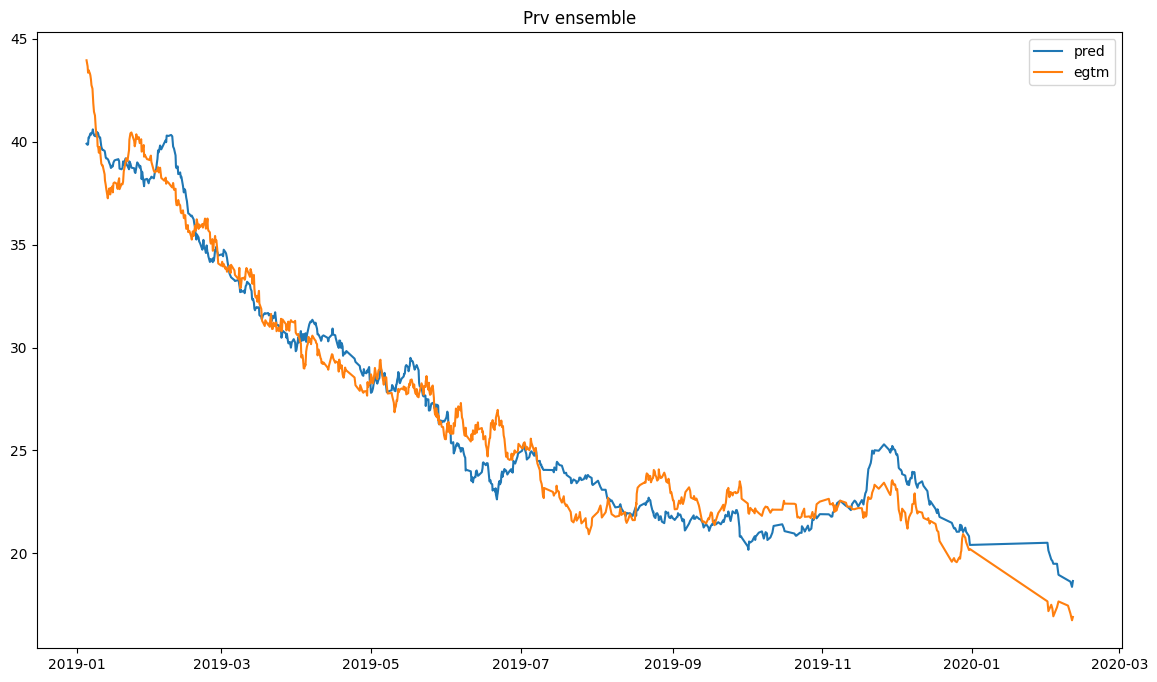

In [6]:
bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()
bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

model = EGTMarginRegressor(bleed_config=['prv'], x_param='n1a_peak', y_param='egt_peak')

train = bgu[0:100]
X = train.drop(columns=['egtm'])
y = train['egtm']

model.fit(X, y)

pred = model.predict(bgu)

print("R2 score = ", model.score(bgu, bgu['egtm']))

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
plt.plot(bgu['reportts'], smooth(pred['pred'], 0.05))
plt.plot(bgu['reportts'], bgu['egtm'])
plt.legend(['pred', 'egtm'])
plt.show()

ACMS Baselines:

In [7]:
bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()
acms_bgu = acms_full.query(f"acnum == 'VQ-BGU' and pos == 2 and n1a_peak > 0 and egt_peak > 0 and tat_peak > -100").copy()
acms_bdu = acms_full.query(f"acnum == 'VQ-BDU' and pos == 2 and n1a_peak > 0 and egt_peak > 0 and tat_peak > -100").copy()

In [79]:
model.ensemble.coef_, model.ensemble.intercept_

(array([1.1093091]), 0.19900217573827916)

In [80]:
acms_bgu.shape

(3804, 206)

/tmp/ipykernel_456587/1835636937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (0 + theta ** alpha2)
/tmp/ipykernel_456587/1835636937.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)


R2 score =  0.9103522386232006


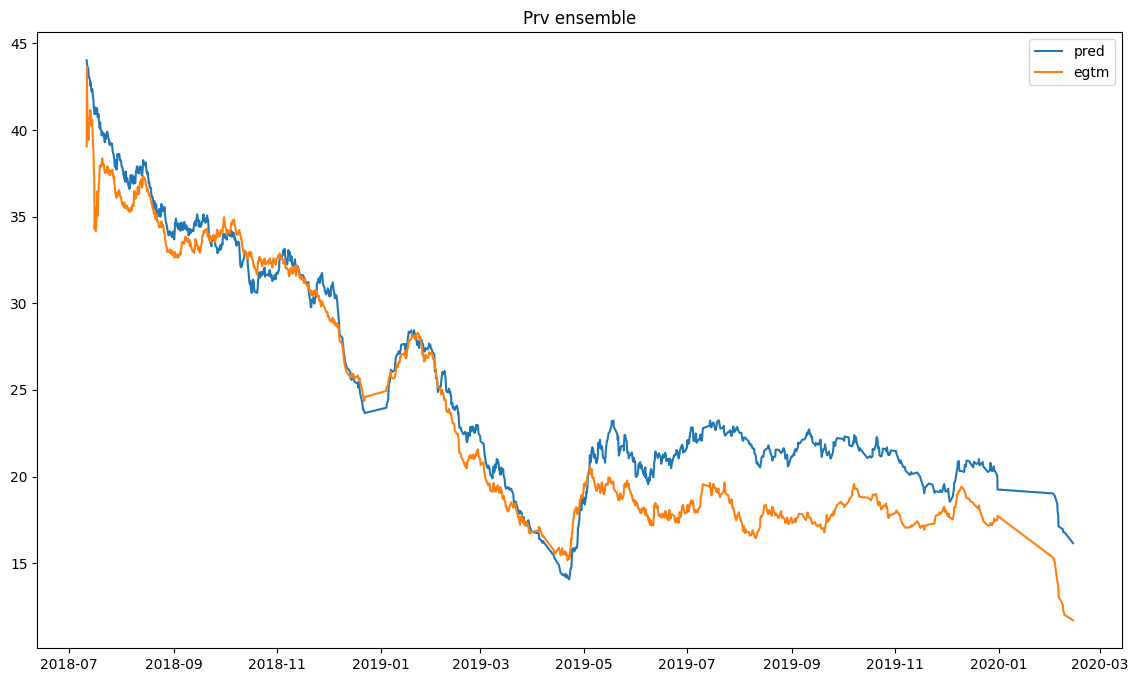

In [13]:
model = EGTMarginRegressor(
  acms_data=acms_bdu[:800], 
  bleed_config=['prv'], 
  x_param='n1a_peak', 
  y_param='egt_peak',
  filter_nan=True
)

train = bdu[200:600]
X = train
y = train['egtm']

model.fit(X, y)

pred = model.predict(bdu)

print("R2 score = ", model.score(bdu, bdu['egtm']))

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
plt.plot(bdu['reportts'], smooth(pred['pred'], 0.05))
plt.plot(bdu['reportts'], bdu['egtm'])
plt.legend(['pred', 'egtm'])
plt.show()

### 1. Gridsearch of x/y/theta variants

Use proper gridsearch utilizing new regressor class

In [ ]:
from sklearn.model_selection import GridSearchCV

best_rmse = 1000
best_model = None
best_pred = None
best_x, best_y, best_th = None, None, None

x_variants = [\
  'n1', 'n1a', 'n1com', 'n1c2', 'n2a', 'n2c5',
  'n2p', 'nf', 'n1_peak', 'n1msa', 'n1p',
  'n1a_peak', 'n1c2_peak', 'n1com_peak', 
  'n1max', 'n1max_peak', 'n2a_peak', 'nf_peak']

y_variants = ['egt', 'egt_peak', 'egtb']

theta_variants = ['oat', 'oat_peak', 't14', 't2', 't25', 't2_peak', 'tat', 'tat_rtd', 'tn', 'tat_peak']

hall_of_fame = []

tat_peak = правильный

In [ ]:
model = EGTMarginRegressor()

train = bgu.copy()
X = train.drop(columns=['egtm'])
y = train['egtm']


grid = GridSearchCV(model, {
  'x_param': x_variants,
  'y_param': y_variants,
  'theta_param': theta_variants
}, n_jobs=-1)

grid.fit(X, y)

GridSearchCV(estimator=EGTMarginRegressor(), n_jobs=-1,
             param_grid={'theta_param': ['oat', 'oat_peak', 't14', 't2', 't25',
                                         't2_peak', 'tat', 'tat_rtd', 'tn',
                                         'tat_peak'],
                         'x_param': ['n1', 'n1a', 'n1com', 'n1c2', 'n2a',
                                     'n2c5', 'n2p', 'nf', 'n1_peak', 'n1msa',
                                     'n1p', 'n1a_peak', 'n1c2_peak',
                                     'n1com_peak', 'n1max', 'n1max_peak',
                                     'n2a_peak', 'nf_peak'],
                         'y_param': ['egt', 'egt_peak', 'egtb']})

In [ ]:
grid.best_params_

{'theta_param': 't2_peak', 'x_param': 'n1msa', 'y_param': 'egt_peak'}

In [ ]:
cv_results = grid.cv_results_

params = cv_results['params']
mean_scores = cv_results['mean_test_score']

param_scores = list(zip(params, mean_scores))

# Sort parameter combinations based on scores
sorted_param_scores = sorted(param_scores, key=lambda x: x[1], reverse=True)

# Get the top n parameter combinations
n = 5  # Specify the number of top parameter combinations you want
top_n_param_combinations = sorted_param_scores[:n]

# Print the top n parameter combinations
print(f"Top {n} parameter combinations:")
for i, (params, score) in enumerate(top_n_param_combinations, start=1):
    print(f"{i}. Parameters: {params}, Mean Test Score: {score}")

Top 5 parameter combinations:
1. Parameters: {'theta_param': 't2_peak', 'x_param': 'n1msa', 'y_param': 'egt_peak'}, Mean Test Score: -0.12496081839825819
2. Parameters: {'theta_param': 't14', 'x_param': 'n1msa', 'y_param': 'egt_peak'}, Mean Test Score: -0.20019688235636973
3. Parameters: {'theta_param': 'tat_peak', 'x_param': 'n1msa', 'y_param': 'egt_peak'}, Mean Test Score: -0.27909681976410167
4. Parameters: {'theta_param': 'oat_peak', 'x_param': 'n1msa', 'y_param': 'egt_peak'}, Mean Test Score: -0.31108838887506124
5. Parameters: {'theta_param': 't2_peak', 'x_param': 'n1_peak', 'y_param': 'egt_peak'}, Mean Test Score: -0.34391998128194423


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

for x_param in x_variants:
  for y_param in y_variants:
    for theta_param in theta_variants:
      bdu = bdu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
      x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
      bdu = theta_correct(bdu, x_param, y_param, theta_param)
      assert bdu.shape[0] >= 250
      baseline = train_engine_baseline(bdu[50:250], x_param_k, y_param_k)
      egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

      X = pd.DataFrame(smooth(egtm, 0.05))
      lin_model = LinearRegression()
      lin_model.fit(X, y=bdu['egtm'])

      pred = lin_model.predict(X)
      
      rmse = root_mean_squared_error(bdu['egtm'], pred)

      if rmse < best_rmse:
        best_pred = pred
        best_rmse = rmse
        best_model = lin_model
        best_x, best_y, best_th = x_param, y_param, theta_param

      hall_of_fame.append({
        'x_param': x_param,
        'y_param': y_param, 
        'theta_param': theta_param,
        'rmse': rmse
      })


In [ ]:
pd.DataFrame(hall_of_fame).sort_values('rmse')[:10]

,x_param,y_param,theta_param,rmse
492,n2a_peak,egt_peak,t14,0.830892
495,n2a_peak,egt_peak,t2_peak,0.854996
499,n2a_peak,egt_peak,tat_peak,0.865870
491,n2a_peak,egt_peak,oat_peak,0.866610
496,n2a_peak,egt_peak,tat,0.950374
120,n2a,egt,oat,1.026282
127,n2a,egt,tat_rtd,1.037091
121,n2a,egt,oat_peak,1.062510
123,n2a,egt,t2,1.066969
129,n2a,egt,tat_peak,1.082192


#### Plot best result: 

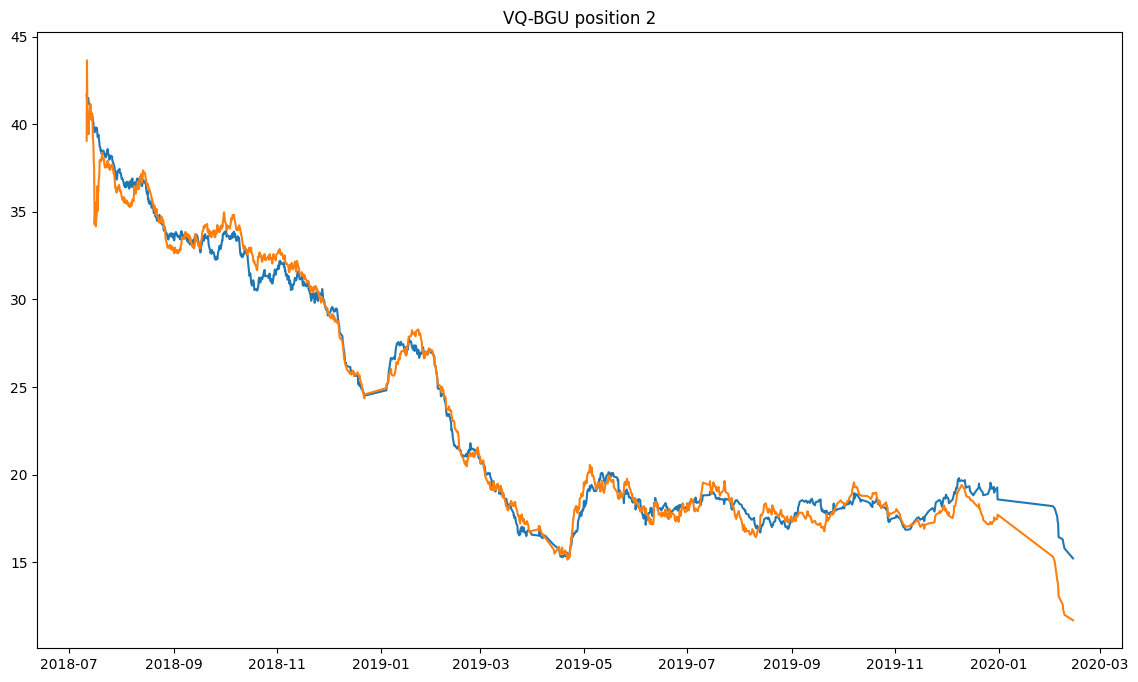

In [ ]:
import matplotlib.pyplot as plt

bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
plt.plot(bdu['reportts'], best_pred)
plt.plot(bdu['reportts'], bdu['egtm'])
plt.show()

### Finetune coefficient for theta corrections

In [ ]:
best_x, best_y, best_th

('n2a_peak', 'egt_peak', 't14')

In [ ]:
best_rmse = 1000
best_a = 1000

factor = 10_000

for a in range(8000, 9000, 1):
  bdu = theta_correct(bdu, best_x, best_y, best_th, alpha2=(a / factor))
  x_param_k, y_param_k = f'{best_x}_k', f'{best_y}_k'
  baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
  egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

  X = pd.DataFrame(smooth(egtm, 0.05))
  lin_model = LinearRegression()
  lin_model.fit(X, y=bdu['egtm'])

  pred = lin_model.predict(X)
  
  rmse = root_mean_squared_error(bdu['egtm'], pred)

  if rmse < best_rmse:
    best_a = a / factor
    best_rmse = rmse

print(best_a, best_rmse)

0.8825 0.8315689377080188


**Result For VQ-BDU pos 2:**

- `alpha_2 = 0.869 (not 0.84)`
- `x_param = n2a_peak`
- `y_param = egt_peak	`
- `theta_param = tat`

For VQ-BGU results are inconsistent; We try to plot deltas applying corrections same as for VQ-BDU

In [ ]:
bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2 and reportts >= "2019-01-01"')
bgu_all.shape

(814, 212)

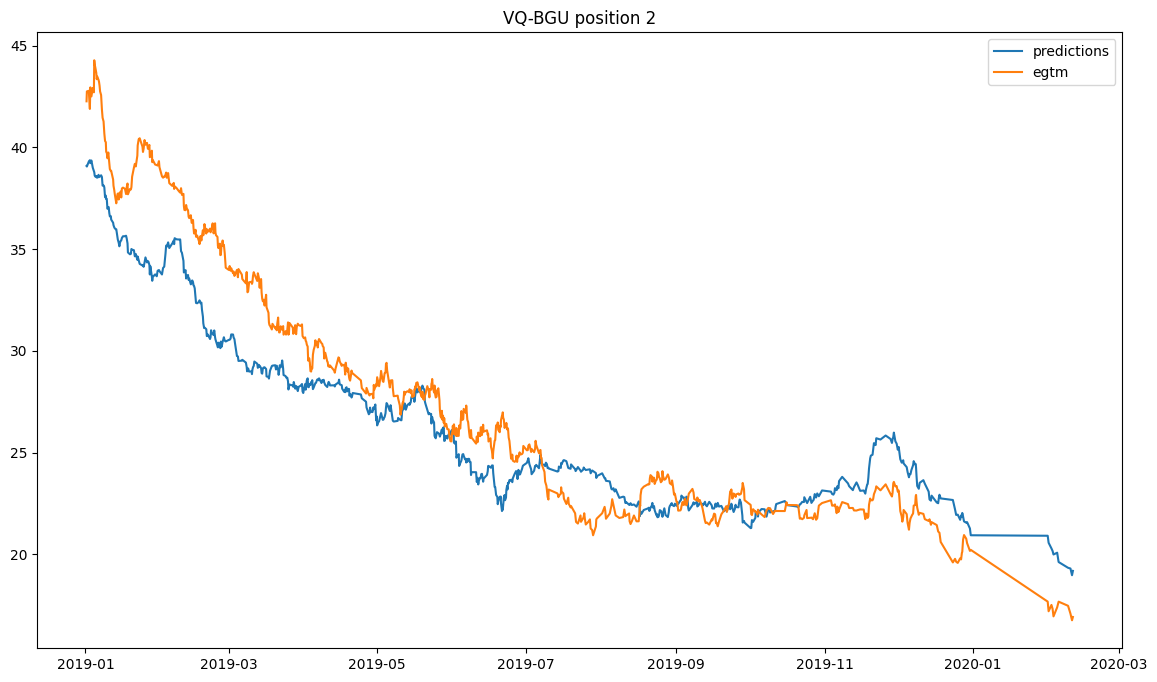

In [ ]:
x_param = "n2a_peak"
y_param = "egt_peak"
theta_param = "tat_peak"

bgu = bgu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
bgu = theta_correct(bgu, x_param, y_param, theta_param)
assert bgu.shape[0] >= 100
baseline = train_engine_baseline(bgu[:100], x_param_k, y_param_k)
egtm = compute_egtm(bgu, baseline, x_param_k, y_param_k)

X = pd.DataFrame(smooth(egtm, 0.05))
lin_model = LinearRegression()
lin_model.fit(X[:100], y=bgu['egtm'][:100])

pred = lin_model.predict(X)

rmse = root_mean_squared_error(bgu['egtm'], pred)

# bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
# plt.plot(bgu['reportts'], pred)
plt.plot(bgu['reportts'], smooth(0.8 * egtm + 7.4, 0.05))
plt.plot(bgu['reportts'], bgu['egtm'])
plt.legend(['predictions', 'egtm'])
plt.show()